In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import librosa
import sys
from pathlib import Path
import os
import shutil

## Information

In [108]:
Subject_name = "sub002"

In [109]:
foundation_path = f"/home/bxai1/BXAI/Project/NeuroTalk-decoder/"

In [110]:
# 부모 경로 추가
parent_dir = Path(foundation_path)
sys.path.append(str(parent_dir))

In [111]:
mel_path = foundation_path + f"Patients/preprocessed/{Subject_name}/about_voice/{Subject_name}_mel/"
voice_path = foundation_path+ f"Patients/preprocessed/{Subject_name}/about_voice/{Subject_name}_csv/"

In [112]:
class_list = {
    1: "call",
    2: "camera",
    3: "down",
    4: "left",
    5: "message",
    6: "music",
    7: "off",
    8: "on",
    9: "receive",
    10: "right",
    11: "turn",
    12: "up",
    13: "volumn"
}

## Define Function

In [113]:
# Vocder
# wav_target = vocoder_voc()
# 이후  wavio.write(path, wav,target, sampling rate, sample width =1)
import json
from models.models_HiFi import Generator as model_HiFi
from modules import DTW_align, GreedyCTCDecoder, AttrDict, RMSELoss
from modules import mel2wav_vocoder
import torchaudio
def vocoder_voc(pd_mel):
    device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else "cpu")
    vocoder_pre = foundation_path + 'pretrained_model/UNIVERSAL_V1/g_02500000'

    wav_target = torch.tensor(pd_mel.values, dtype=torch.float32).unsqueeze(0).to(device)
    
    # vocoder HiFiGAN
    # LJ_FT_T2_V3/generator_v3,   
    config_file = os.path.join(os.path.split(vocoder_pre)[0], 'config.json')
    with open(config_file) as f:
        data = f.read()

    json_config = json.loads(data)
    h = AttrDict(json_config)
    vocoder = model_HiFi(h).cuda()
    state_dict_g = torch.load(vocoder_pre) #, map_location=args.device)
    vocoder.load_state_dict(state_dict_g['generator'])
    wav_target = mel2wav_vocoder(wav_target,vocoder,1)
    wav_target = torchaudio.functional.resample(wav_target, 22050, 16000)
    return wav_target

In [114]:
import torch
import torchaudio
import numpy as np
import librosa

def pitch_shift(data, sr, n_steps):
    data = data.cpu().numpy()  # Move data to CPU and convert to numpy array
    shifted_data = librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)
    return torch.tensor(shifted_data).float().cuda()  # Move data back to GPU

def time_stretch(data, original_length, rate=1.0):
    data = data.cpu().numpy()  # Move data to CPU and convert to numpy array
    stretched_data = librosa.effects.time_stretch(data, rate=rate)
    
    # Adjust length to match original length
    if len(stretched_data) > original_length:
        stretched_data = stretched_data[:original_length]
    else:
        padding = np.zeros(original_length - len(stretched_data))
        stretched_data = np.concatenate((stretched_data, padding))
    
    return torch.tensor(stretched_data).float().cuda()  # Move data back to GPU

def add_noise(data, noise_factor):
    noise = torch.randn_like(data) * noise_factor
    return data + noise

def shift_voice(data, shift_step):
    return torch.roll(data, shifts=shift_step)

def emphasis(data, gain=1.0):
    emphasized_data = data * gain
    return emphasized_data

def generate_augmentations(data, sr, num_augmentations=30):
    augmentations = []
    
    data = torch.tensor(data).float().cuda()  # Move data to GPU
    
    for _ in range(num_augmentations):
        augmented_data = data.clone()
        
        # Apply random pitch shift
        n_steps = np.random.uniform(-3, 3)  # Randomly choose pitch shift steps between -3 and 3
        augmented_data = pitch_shift(augmented_data, sr, n_steps)
        
        # Apply random time stretch
        rate = np.random.uniform(0.9, 1.1)  # Randomly choose time stretch rate between 0.9 and 1.1
        augmented_data = time_stretch(augmented_data, 88200, rate)
        
        # Apply random noise
        noise_factor = np.random.uniform(0.002, 0.005)  # Randomly choose noise factor between 0.002 and 0.005
        augmented_data = add_noise(augmented_data, noise_factor)
        
        # Apply random shift
        shift_step = np.random.randint(0, len(augmented_data)//8)  # Randomly choose shift step
        augmented_data = shift_voice(augmented_data, shift_step)
        
        # Apply random emphasis
        gain = np.random.uniform(0.8, 1.5)  # Randomly choose gain for emphasis
        augmented_data = emphasis(augmented_data, gain)
        
        augmentations.append(augmented_data.cpu().numpy())  # Move data back to CPU and convert to numpy array
    
    return augmentations


In [115]:
import noisereduce as nr
import torchaudio
def make_mel(y_voice):   
    # resampling
    sampling_rate_ori = 44100
    sampling_rate = 22050

    y_voice = torchaudio.functional.resample(y_voice, sampling_rate_ori, sampling_rate)

    # Noise reduction
    y_voice_nr = nr.reduce_noise(y=y_voice, sr=sampling_rate)
    y_voice_nr = torch.Tensor(y_voice_nr)

    # 2. STFT and conversion into Mel-spectrogram
    n_fft = 1024
    win_length = 1024
    hop_length = win_length//4
    n_mel_channels = 80

    mel_fmin=0.0
    mel_fmax= 8000.0
    hann_window = torch.hann_window(win_length)


    mel_basis = librosa.filters.mel(sr=sampling_rate, n_fft=n_fft,n_mels=n_mel_channels, fmin=mel_fmin,fmax=mel_fmax)
    mel_basis = torch.from_numpy(mel_basis)

    p = (n_fft - hop_length) // 2
    y = F.pad(y_voice_nr, (p, p))

    spec = torch.stft(y,
                    n_fft,
                    hop_length=hop_length,
                    win_length=win_length,
                    window=hann_window,
                    center=False,
                    return_complex=False
                    )

    magnitude = torch.sqrt(spec[:,:,0]**2 + spec[:,:,1]**2)
    mel = torch.matmul(mel_basis, magnitude)
    mel = torch.log(torch.clamp(mel, min=1e-5))
    return mel

In [116]:
def plot_mel(melmel):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(melmel.detach().numpy(), x_axis='time', y_axis='mel', sr=22050,
                                hop_length=1024//4, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')
    plt.show()
    return

In [117]:
def write_mel(mel, i, j):
    path_mel = foundation_path + f"Patients/preprocessed/{Subject_name}/pre_trained/mel/{class_list[i]}/"
    mel_pd = pd.DataFrame(mel)
    mel_pd.to_csv(path_mel+f"{j}.csv", header=None, index=None)

In [118]:
import wavio
import os
def wavio_write(wav_target,i,j,sr):
    path_voice = foundation_path + f"Patients/preprocessed/{Subject_name}/pre_trained/wav/{class_list[i]}/"
    if isinstance(wav_target, torch.Tensor):
        wav_target = wav_target.detach().cpu().numpy().squeeze()

    wavio.write(path_voice+f"{j}.wav", wav_target,sr,sampwidth=2)
    return

In [119]:
spoken_EEG = pd.read_csv(foundation_path + f"Patients/preprocessed/{Subject_name}/Spoken/{Subject_name}_spoken_EEG_preprocessed.csv", index_col = 0)
all_label = spoken_EEG.values[:,-1]

In [120]:
all_label = all_label[all_label!=1]
ind = np.where(np.diff(all_label)!=0)[0]+1
m_label = all_label[ind]
mod_label = m_label[m_label !=0]
mod_label = mod_label-1
mod_label

array([12., 12., 12., 12.,  3.,  3.,  3.,  3., 11., 11., 11., 11., 13.,
       13., 13., 13.,  2.,  2.,  2.,  2.,  7.,  7.,  7.,  7.,  6.,  6.,
        6.,  6.,  5.,  5.,  5.,  5.,  4.,  4.,  4.,  4.,  1.,  1.,  1.,
        1.,  9.,  9.,  9.,  9., 10., 10., 10., 10.,  8.,  8.,  8.,  8.,
       10., 10., 10., 10., 12., 12., 12., 12.,  9.,  9.,  9.,  9.,  1.,
        1.,  1.,  1., 13., 13., 13., 13.,  2.,  2.,  2.,  2., 11., 11.,
       11., 11.,  8.,  8.,  8.,  8.,  5.,  5.,  5.,  5.,  4.,  4.,  4.,
        4.,  6.,  6.,  6.,  6.,  3.,  3.,  3.,  3.,  7.,  7.,  7.,  7.,
        4.,  4.,  4.,  4., 11., 11., 11., 11.,  5.,  5.,  5.,  5., 12.,
       12., 12., 12.,  9.,  9.,  9.,  9.,  3.,  3.,  3.,  3., 10., 10.,
       10., 10.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  1.,  1.,  1.,
        1.,  2.,  2.,  2.,  2., 13., 13., 13., 13.,  8.,  8.,  8.,  8.,
       13., 13., 13., 13., 11., 11., 11., 11., 12., 12., 12., 12.,  8.,
        8.,  8.,  8.,  4.,  4.,  4.,  4.,  2.,  2.,  2.,  2., 10

In [121]:
all_label

array([0., 0., 0., ..., 2., 2., 2.])

## Voice Augmentation

In [122]:
import warnings

voice_list = sorted(os.listdir(voice_path))
for component in voice_list:
    if component[0] == '.':
        voice_list.remove(component)
# Function to process augmentation and mel-spectrogram creation
def process_augmentation_and_mel(mod_label):
    # Create necessary directories for mel and wav files if they don't exist
    for i in range(0, len(voice_list)):    
        path_mel = foundation_path + f"Patients/preprocessed/{Subject_name}/pre_trained/mel/{class_list[mod_label[i]]}/"
        path_voice = foundation_path + f"Patients/preprocessed/{Subject_name}/pre_trained/wav/{class_list[mod_label[i]]}/"
        if not os.path.exists(path_mel):
            os.makedirs(path_mel, exist_ok=True)
        if not os.path.exists(path_voice):
            os.makedirs(path_voice, exist_ok=True)

    # Process each voice file, apply augmentations, and convert to mel-spectrograms
    for i in range(0, len(voice_list)):
        wav_data = pd.read_csv(voice_path + voice_list[i]).values.squeeze()
        sample_rate = 44100
        augmented_data_list = generate_augmentations(wav_data, sample_rate, num_augmentations=769*2)
        for j, data in enumerate(augmented_data_list):
            try:
                # Use warning filter to catch the specific warning about stft
                with warnings.catch_warnings(record=True) as w:
                    warnings.simplefilter("always")  # Trigger mod warnings

                    melmel = make_mel(torch.tensor(data))  # Create mel-spectrogram

                    # Check if the specific warning about return_complex was raised
                    if any('return_complex' in str(warn.message) for warn in w):
                        print("return_complex warning detected. Restarting process after clearing directories.")
                        clear_directories_and_restart()
                        return  # Exit and restart the process

                write_mel(melmel, i + 1, j + 1)  # Save mel-spectrogram
                wavio_write(data, i + 1, j + 1, 44100)  # Save augmented wav data

            except Exception as e:
                print(f"Error occurred during processing: {e}")
                raise e  # Re-raise the exception if it's not a warning

# Function to clear directories and restart the process
def clear_directories_and_restart():
    overal_path_mel = foundation_path + f"Patients/preprocessed/{Subject_name}/pre_trained/mel/"
    overal_path_voice = foundation_path + f"Patients/preprocessed/{Subject_name}/pre_trained/wav/"
    
    # Delete directories if they exist
    if os.path.exists(overal_path_mel):
        shutil.rmtree(overal_path_mel)
    if os.path.exists(overal_path_voice):
        shutil.rmtree(overal_path_voice)

    print("Delete Path Complete")
    process_augmentation_and_mel(mod_label)  # Restart the entire process after clearing directories

# Initial execution
try:
    process_augmentation_and_mel(mod_label)
except Exception as e:
    print(f"Error occurred: {e}")


Error occurred during processing: 14
Error occurred: 14


In [123]:
aug_mel = foundation_path + f"Patients/preprocessed/{Subject_name}/pre_trained/mel/"
ori_dataset= None
class_li = os.listdir(aug_mel)
for i in range(len(class_li)):
    class_path = aug_mel+class_li[i]+'/'
    for j in range(len(os.listdir(class_path))):
        if ori_dataset is None:
            ori_dataset = torch.tensor(pd.read_csv(class_path+f"{j+1}.csv", header=None).values,dtype=torch.float).unsqueeze(0)
        else:
            ori_dataset = torch.concat([ori_dataset, torch.tensor(pd.read_csv(class_path+f"{j+1}.csv", header=None).values,dtype=torch.float).unsqueeze(0)],axis=0)
            print(ori_dataset.shape)


torch.Size([2, 80, 172])
torch.Size([3, 80, 172])
torch.Size([4, 80, 172])
torch.Size([5, 80, 172])
torch.Size([6, 80, 172])
torch.Size([7, 80, 172])
torch.Size([8, 80, 172])
torch.Size([9, 80, 172])
torch.Size([10, 80, 172])
torch.Size([11, 80, 172])
torch.Size([12, 80, 172])
torch.Size([13, 80, 172])
torch.Size([14, 80, 172])
torch.Size([15, 80, 172])
torch.Size([16, 80, 172])
torch.Size([17, 80, 172])
torch.Size([18, 80, 172])
torch.Size([19, 80, 172])
torch.Size([20, 80, 172])
torch.Size([21, 80, 172])
torch.Size([22, 80, 172])
torch.Size([23, 80, 172])
torch.Size([24, 80, 172])
torch.Size([25, 80, 172])
torch.Size([26, 80, 172])
torch.Size([27, 80, 172])
torch.Size([28, 80, 172])
torch.Size([29, 80, 172])
torch.Size([30, 80, 172])
torch.Size([31, 80, 172])
torch.Size([32, 80, 172])
torch.Size([33, 80, 172])
torch.Size([34, 80, 172])
torch.Size([35, 80, 172])
torch.Size([36, 80, 172])
torch.Size([37, 80, 172])
torch.Size([38, 80, 172])
torch.Size([39, 80, 172])
torch.Size([40, 80, 

## Save & Load Data

In [124]:
import pickle
with open(foundation_path + f'Patients/preprocessed/{Subject_name}/pre_trained/data.pkl', 'wb') as f:
     pickle.dump(ori_dataset, f)

In [125]:
import pickle
with open(foundation_path + f'Patients/preprocessed/{Subject_name}/pre_trained/data.pkl', 'rb') as f:
    ori_dataset = pickle.load(f)

## Dataset & DataLoader

In [126]:
ori_dataset = ori_dataset.unsqueeze(1)
ori_dataset.shape

torch.Size([19994, 1, 80, 172])

In [127]:
label = None
for i in range(13):
    for j in range(769*2):
        la = torch.tensor([i], dtype=torch.long)
        if label is None:
            label = la
        else:
            label = torch.concat([label, la])

In [128]:
label.shape

torch.Size([19994])

In [129]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ori_dataset, label, test_size=0.2, shuffle = True, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle = True, random_state = 42)

In [130]:
import torch
from torch.utils.data import DataLoader

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X.values if isinstance(X, pd.DataFrame) else X
        self.y = y.values if isinstance(y, pd.DataFrame) else y
        if isinstance(self.X, torch.Tensor):
            self.X = X.type(torch.float32)
        else:
            self.X = torch.tensor(self.X, dtype=torch.float32)
            
        if isinstance(self.y, torch.Tensor):
            self.y = y.type(torch.long)
        else:
            self.y = torch.tensor(self.y, dtype=torch.long)
        
    def __getitem__(self, index):
        
        x = self.X[index]
        y = self.y[index]
        return x, y
    
    def __len__(self):
        return len(self.X)
    
train_dataset = Dataset(X_train, y_train)
val_dataset = Dataset(X_val, y_val)
test_dataset = Dataset(X_test, y_test)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

## Define ResNet-18

In [131]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# 모델 인스턴스 생성
model = resnet18(num_classes=13)


## Train & Valid

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 모델 정의 (앞서 정의한 ResNet-18 사용)
def resnet18(num_classes=13):  # CIFAR-10은 10개의 클래스가 있음
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_graph = []
accuracy_graph = []

# 모델, 손실 함수 및 옵티마이저 설정
model = resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 옵티마이저 초기화
        optimizer.zero_grad()
        
        # 순전파 + 역전파 + 최적화
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 손실 출력
        running_loss += loss.item()
    loss_graph.append(running_loss/len(trainloader))
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')

    # 검증 단계
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy_graph.append(100 * correct / total)
    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

print('Finished Training')

Epoch [1/20], Loss: 0.2650
Accuracy of the model on the test images: 99.39984996249062%
Epoch [2/20], Loss: 0.0152
Accuracy of the model on the test images: 99.29982495623906%
Epoch [3/20], Loss: 0.0291
Accuracy of the model on the test images: 38.40960240060015%
Epoch [4/20], Loss: 0.0051
Accuracy of the model on the test images: 99.84996249062266%
Epoch [5/20], Loss: 0.0023
Accuracy of the model on the test images: 99.89997499374844%
Epoch [6/20], Loss: 0.0067
Accuracy of the model on the test images: 82.12053013253313%
Epoch [7/20], Loss: 0.0019
Accuracy of the model on the test images: 100.0%
Epoch [8/20], Loss: 0.0037
Accuracy of the model on the test images: 92.64816204051013%
Epoch [9/20], Loss: 0.0025
Accuracy of the model on the test images: 94.37359339834958%
Epoch [10/20], Loss: 0.0079
Accuracy of the model on the test images: 96.07401850462615%
Epoch [11/20], Loss: 0.0066
Accuracy of the model on the test images: 81.74543635908977%
Epoch [12/20], Loss: 0.0091
Accuracy of th

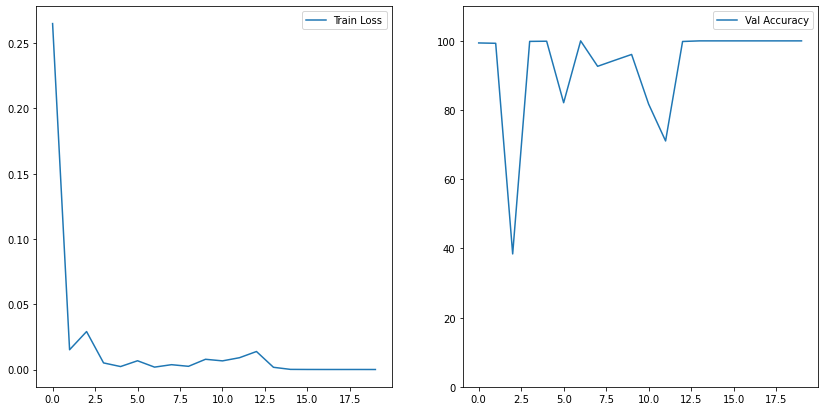

In [133]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(loss_graph, label="Train Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(accuracy_graph, label = "Val Accuracy")
plt.ylim(0,110)
plt.legend()

In [134]:
torch.save(model, foundation_path + f"Patients/preprocessed/{Subject_name}/pre_trained/CNN_{Subject_name}.pt")

In [135]:
asd = torch.load(foundation_path + f"Patients/preprocessed/{Subject_name}/pre_trained/CNN_{Subject_name}.pt")
asd

/tmp/ipykernel_1086864/166621766.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  asd = torch.load(foundation_path + f"Patients/preprocessed/{Subject_name}/pre_trained/CN

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    